In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

warnings.filterwarnings("ignore")

import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set_style("dark")
sns.set_theme(style="darkgrid", palette="deep")

from scripts.utils import get_runs_data, read_yaml
from scripts.components.preprocessing import PreprocessingComponent
from scripts.components.eda import EDAComponent
from scripts.components.matrix_builder import MatrixBuilderComponent
from scripts.components.features_generator import FeaturesGeneratorComponent
from scripts.components.als import ALSModelComponent
from scripts.components.bpr import BPRModelComponent
from scripts.components.item2item import Item2ItemModelComponent
from scripts.components.top_items import TopItemsModelComponent
from scripts.components.ensemble import EnsembleModelComponent

2024-12-03 18:06:40,834 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/config/components.yaml has been loaded
2024-12-03 18:06:40,837 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/config/dates.yaml has been loaded
2024-12-03 18:06:40,842 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/config/airflow.yaml has been loaded
2024-12-03 18:06:40,851 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/config/experiment_name.yaml has been loaded


# <p style="color: #33FF33; text-align:center;"> STAGE I. Data preprocessing</p>

## <p style="color: #999900;"> 1. Data preprocessing </p>

In [3]:
preprocessor = PreprocessingComponent(print_info=True)

### <p style="color: #FFB266;"> 1.1. events </p>

In [4]:
preprocessor.preprocess_events()

2024-12-03 14:49:16,844 [recsys_experiments] [read_parquet] - INFO: Read events.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/raw.

----- 'events' dataframe info before preprocessing -----

-- info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB
None

-- sample --
|    |     timestamp |   visitorid | event   |   itemid |   transactionid |
|---:|--------------:|------------:|:--------|---------:|----------------:|
|  0 | 1433221332117 |      257597 | view    |   355908 |             nan |
|  1 | 1433224214164 |      992329 | view    |   248676 |             nan |
|  2 | 1433221999827 |      111016 | view    |   31

Important note: events with at least `add to cart` event are considered for the target and test sets since the task is to recommend items that a user will likely `add to cart`

It can be seen that:
- There is no data in `transactionid` column where the `event` is not a transaction. 
    Essentially, this id will not bring any useful information, so this column will be dropped.
- There are very few duplicates along all columns, which have been dropped.
- 20 % of the rows are duplicates if to consider [`user`, `item`, `rating`] as a subset.  
This means that some users have at least viewed a single item multiple times.
- Date column have a precision up to seconds, so we are dealing with very detailed time information.  
    It will be possible to generate a lot of user-item features.

- There are:
    - total: 1407580 `users`, 235061 `items`, 2752009 `events`, 99.9992% `sparsity`
    - train: 90.85% `users`, 95.85% `items`, 90.93% `events`, 99.9991% `sparsity`
    - test: 0.26% `users`, 1.78% `items`, 0.29% `events`, 99.9478% `sparsity`
    - test only: 0.23% `users`  
    
Unsuprisingly, there are new `users` in the test set. These `users` can't be used when building any recommendation model apart from the simplest one, which recommends the most popular `items` that were at least `added to cart`.

The test set was further splited into target and test subsets.
    
Since the sparsity is huge, it is a good idea to check if there are any `items` with very low number of `events` - those `items` can be considered as a noise and omitted when building a recommendation model.

As for `event` column, it was encoded as follows:
- `view`: 1
- `add to cart`: 2
- `transaction`: 3

This way the higher the encoded value the better the event is. These values can be used later on in the collaborative models as some kind of weight - therefore a model will treat at least `add to cart` events with more importance

### <p style="color: #FFB266;"> 1.2. category_tree </p>

In [5]:
preprocessor.preprocess_category_tree()

2024-12-03 11:33:55,468 [recsys_experiments] [read_parquet] - INFO: Read category_tree.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/raw.

----- category_tree dataframe info before preprocessing -----

-- info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB
None

-- sample --
|    |   categoryid |   parentid |
|---:|-------------:|-----------:|
|  0 |         1016 |        213 |
|  1 |          809 |        169 |
|  2 |          570 |          9 |
|  3 |         1691 |        885 |
|  4 |          536 |       1691 |

-- missing data count --
|            |   0 |
|:-----------|----:|
| categoryid |   0 |
| parentid   |  25 |

-- duplicates count --
0 (0.0%)


2024

`category_tree` dataframe:

- There was some missing data for parentid, which basically means that a corresponing categoryid is an isolated node.
- There are 1669 `item_categories`
- There are no duplicates

### <p style="color: #FFB266;"> 1.3. item properties </p>

In [6]:
preprocessor.preprocess_item_properties()

2024-12-03 11:34:06,212 [recsys_experiments] [read_parquet] - INFO: Read item_properties.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/raw.
2024-12-03 11:34:12,844 [recsys_experiments] [save_parquet] - INFO: Saved category.parquet to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
2024-12-03 11:34:17,094 [recsys_experiments] [save_parquet] - INFO: Saved availability.parquet to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.

Total number of items: 417053


----- 'item_category' dataframe info -----

-- info --
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 788214 entries, 0 to 788213
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype        
---  ------      --------------   -----        
 0   itemid      788214 non-null  int64        
 1   timestamp   788214 non-null  datetime64[s]
 2   categoryid  788214

One important note, that the the part of the item properties data with hashed properties and values will not be used for now  
and the focus will be on the item properties with the data about item category and item availability

1. There are 417053 items in total
2. All items have data about category and availability
3. There is not missing data
4. Few items have changed its category through time (one item has changed its category 18 times).  
5. Each item was not available 105 days and was available 76 days on average.
6. Only 16.5% of the total number of items is currently available

With the given data and category tree data it is possible to do the following:
- consider only available items when making recommendations, but consider all items when training the models so that all historical data is used
- Generate features like:
    - mean number of days an item was not available
    - mean number of days an item was available
    - number of times an item has changed its category
- consider item2item model considering root categories and leaf categories separetely

## <p style="color: #999900;"> 2. Logging </p>

In [ ]:
preprocessor.log()

In [ ]:
exit(0)

: 

# <p style="color: #33FF33; text-align:center;"> STAGE II. EDA</p>

<p style="color: #FF0000; font-size:24px;"> Restart the notebook before proceeding </p>

In [5]:
component = EDAComponent()

## <p style="color: #999900;"> 1. User-related analysis </p>

2024-12-03 11:38:55,888 [recsys_experiments] [read_parquet] - INFO: Read events_train.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.

----- ITEMS PER USER FOR RATING 1 -----

Number of unique users: 1275810

Quantiles
|    |   quantiles |   items_per_user |
|---:|------------:|-----------------:|
|  0 |       0.1   |                1 |
|  1 |       0.2   |                1 |
|  2 |       0.3   |                1 |
|  3 |       0.4   |                1 |
|  4 |       0.5   |                1 |
|  5 |       0.6   |                1 |
|  6 |       0.7   |                1 |
|  7 |       0.8   |                2 |
|  8 |       0.9   |                3 |
|  9 |       0.95  |                5 |
| 10 |       0.99  |               12 |
| 11 |       0.999 |               43 |


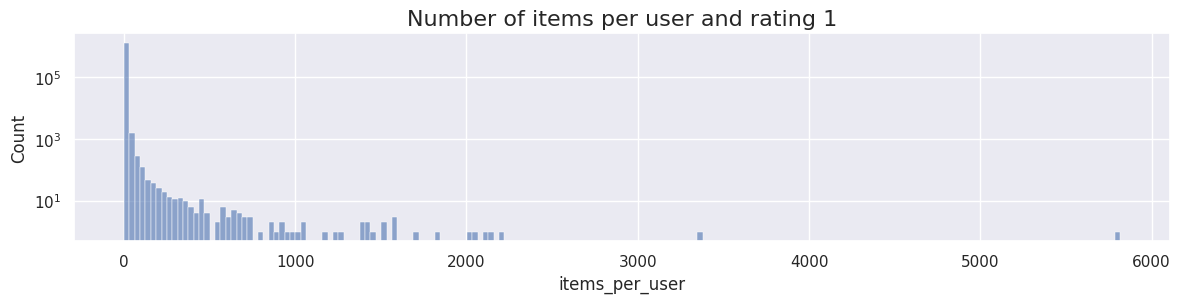

2024-12-03 11:38:58,695 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/items_per_user_rating_1_hist.png


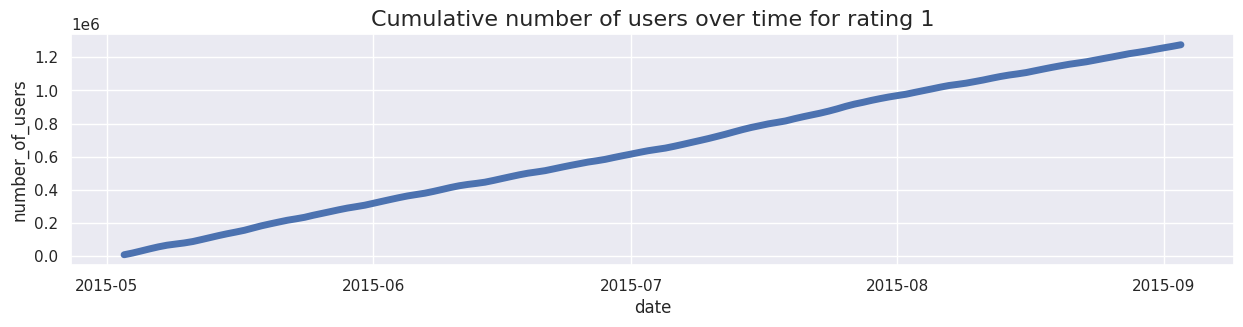

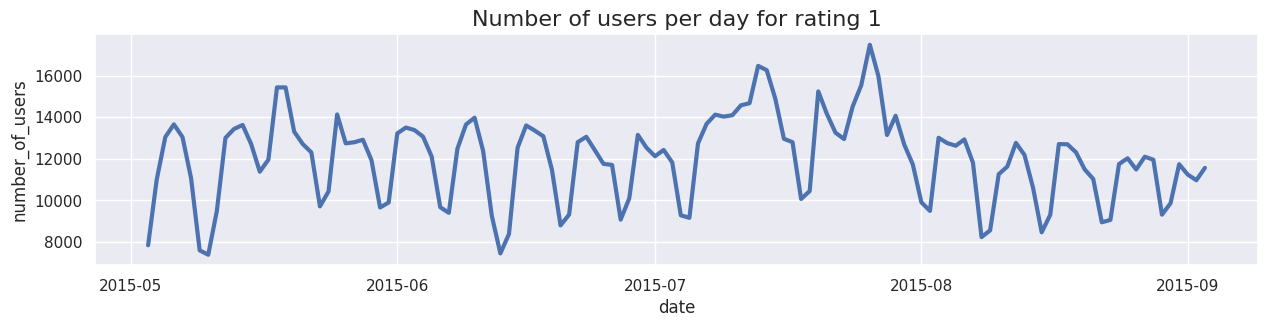


----- ITEMS PER USER FOR RATING 2 -----

Number of unique users: 34309

Quantiles
|    |   quantiles |   items_per_user |
|---:|------------:|-----------------:|
|  0 |       0.1   |                1 |
|  1 |       0.2   |                1 |
|  2 |       0.3   |                1 |
|  3 |       0.4   |                1 |
|  4 |       0.5   |                1 |
|  5 |       0.6   |                1 |
|  6 |       0.7   |                1 |
|  7 |       0.8   |                2 |
|  8 |       0.9   |                3 |
|  9 |       0.95  |                4 |
| 10 |       0.99  |               11 |
| 11 |       0.999 |               69 |


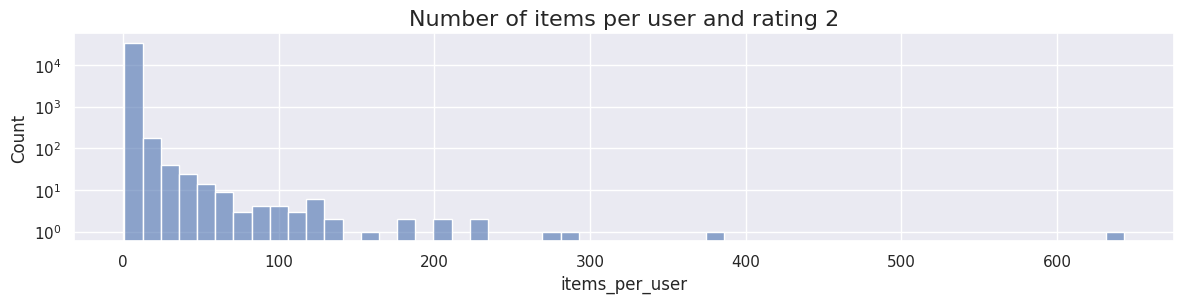

2024-12-03 11:39:01,505 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/items_per_user_rating_2_hist.png


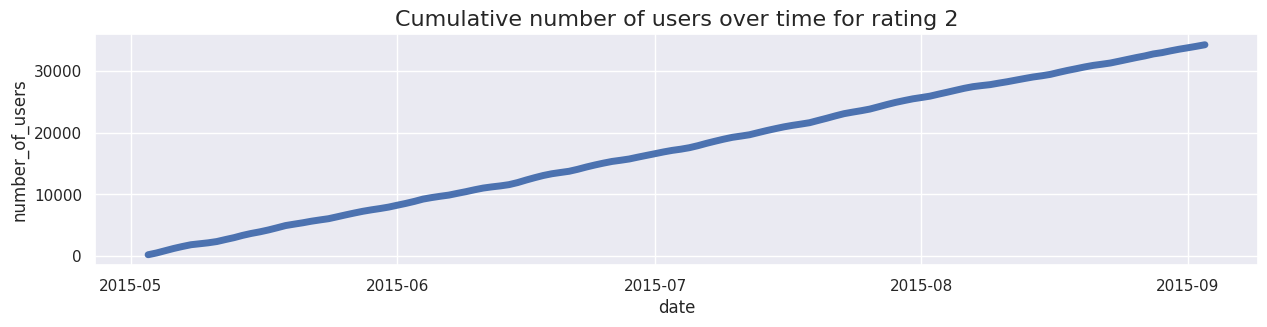

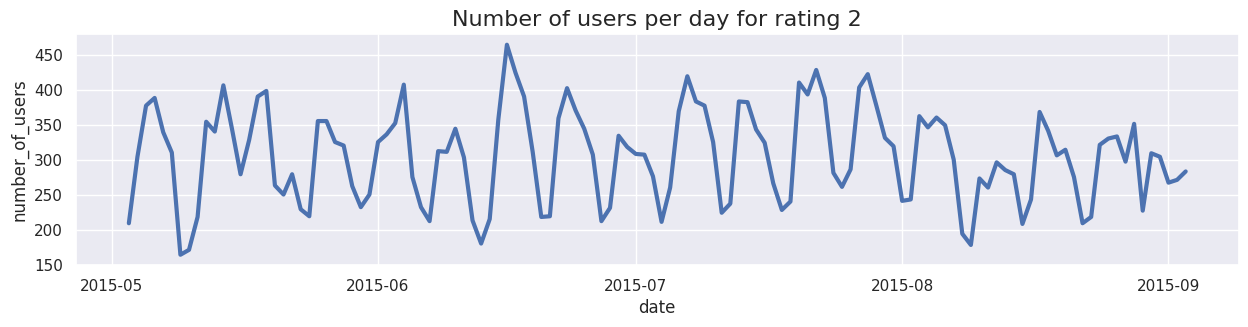


----- ITEMS PER USER FOR RATING 3 -----

Number of unique users: 10708

Quantiles
|    |   quantiles |   items_per_user |
|---:|------------:|-----------------:|
|  0 |       0.1   |            1     |
|  1 |       0.2   |            1     |
|  2 |       0.3   |            1     |
|  3 |       0.4   |            1     |
|  4 |       0.5   |            1     |
|  5 |       0.6   |            1     |
|  6 |       0.7   |            1     |
|  7 |       0.8   |            2     |
|  8 |       0.9   |            2     |
|  9 |       0.95  |            4     |
| 10 |       0.99  |           13     |
| 11 |       0.999 |          104.223 |


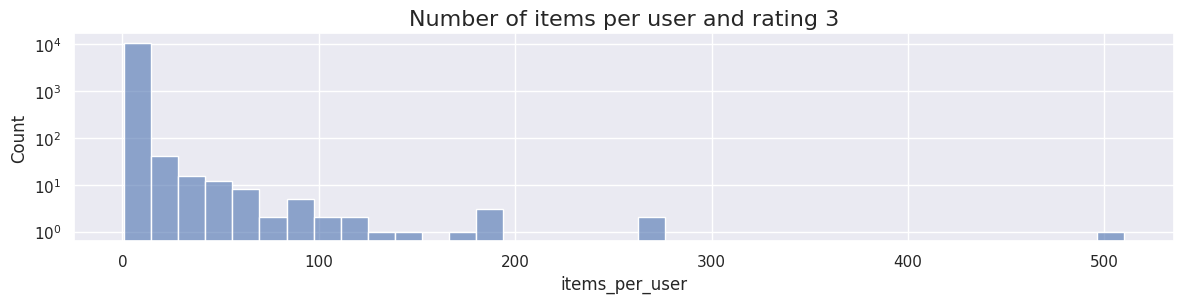

2024-12-03 11:39:03,044 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/items_per_user_rating_3_hist.png


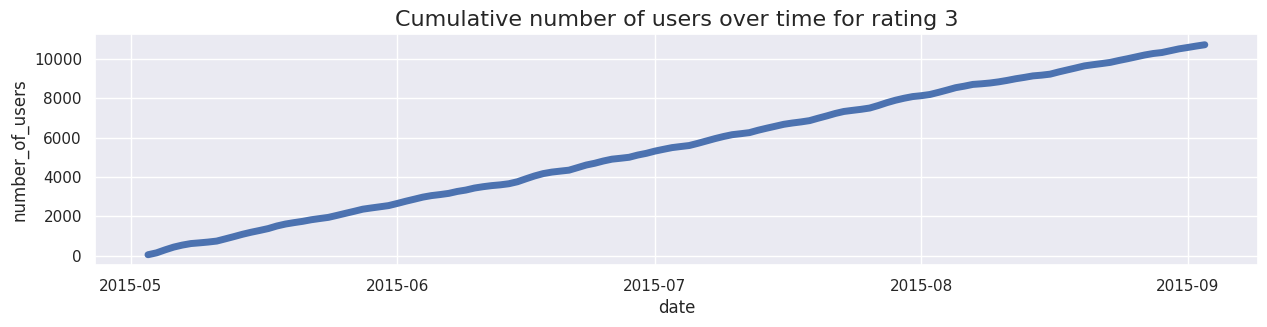

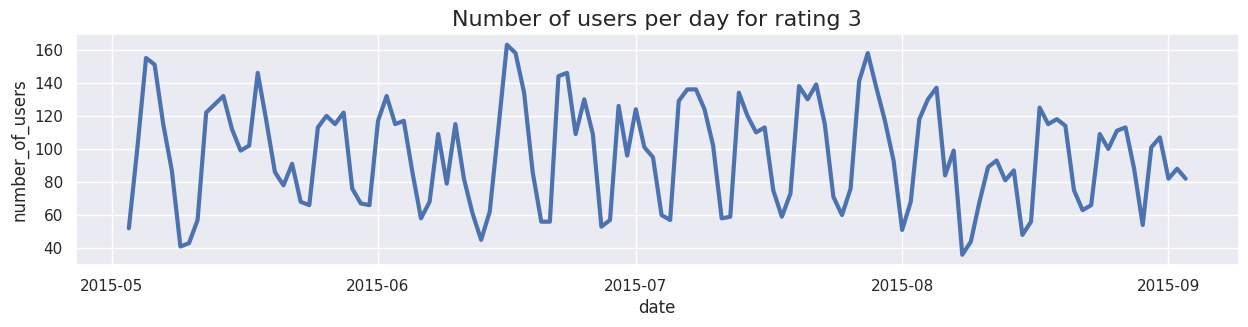

2024-12-03 11:39:03,880 [recsys_experiments] [user_analysis] - INFO: Finished user analysis


In [18]:
component.user_analysis()

1. Top users according to the activity lie far from the rest users according to the hist plots.   
It is highly likely, that those users represent some companies that usually buy a lot of items.  
Therefore, it is better to separate those user from the rest later on by considering a threshold value for a maximum `number of items per user`
2. 70 % of users within the rating groups interacted only with a single item
3. There are very few users that `added to cart` at least one item (34309 out of 1275810)
4. The `transaction` to `add to cart` ratio is not that low (10708 to 34309).
5. The `number of users per day` have a clear week and month seasonality with no clear trend for all ratings.   
This means that certain lag features might be important
6. Though there is no clear trend for `number of users per day`, the `number of users` is constantly increasing for all ratings.

## <p style="color: #999900;"> 2. Item-related analysis </p>

2024-12-03 11:39:09,111 [recsys_experiments] [read_parquet] - INFO: Read events_train.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.

----- USERS PER ITEM FOR RATING 1 -----

Number of unique items: 225099

Quantiles
|    |   quantiles |   users_per_item |
|---:|------------:|-----------------:|
|  0 |       0.1   |                1 |
|  1 |       0.2   |                1 |
|  2 |       0.3   |                1 |
|  3 |       0.4   |                2 |
|  4 |       0.5   |                3 |
|  5 |       0.6   |                4 |
|  6 |       0.7   |                6 |
|  7 |       0.8   |               11 |
|  8 |       0.9   |               23 |
|  9 |       0.95  |               43 |
| 10 |       0.99  |              129 |
| 11 |       0.999 |              381 |


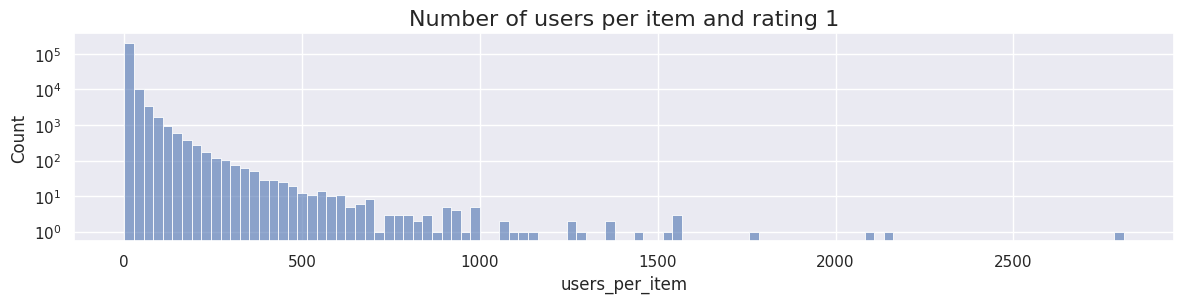

2024-12-03 11:39:10,460 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/users_per_item_rating_1_hist.png


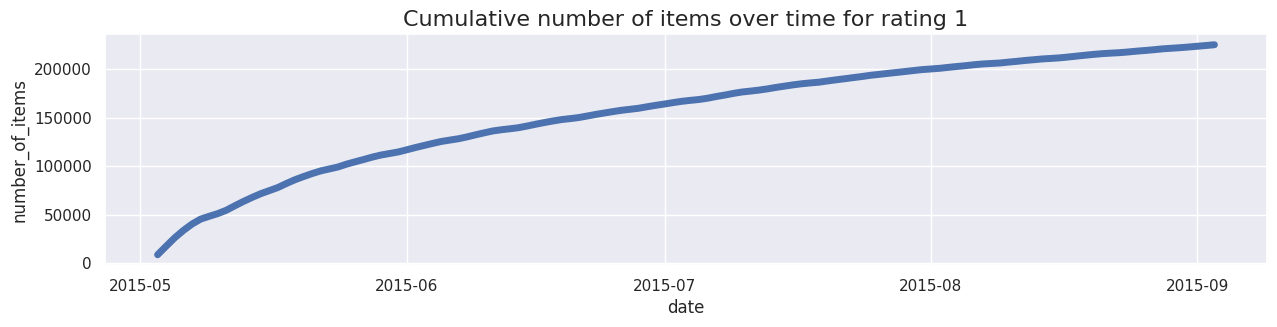

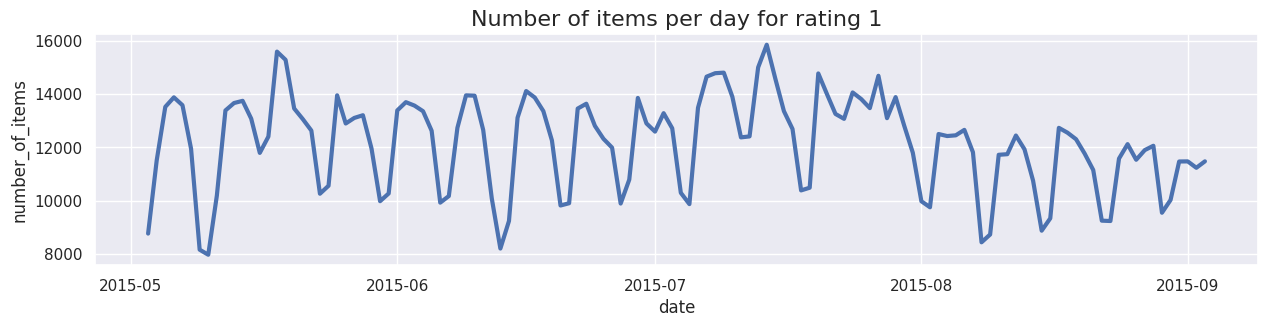


----- USERS PER ITEM FOR RATING 2 -----

Number of unique items: 22347

Quantiles
|    |   quantiles |   users_per_item |
|---:|------------:|-----------------:|
|  0 |       0.1   |            1     |
|  1 |       0.2   |            1     |
|  2 |       0.3   |            1     |
|  3 |       0.4   |            1     |
|  4 |       0.5   |            2     |
|  5 |       0.6   |            2     |
|  6 |       0.7   |            2     |
|  7 |       0.8   |            3     |
|  8 |       0.9   |            5     |
|  9 |       0.95  |            8     |
| 10 |       0.99  |           18     |
| 11 |       0.999 |           50.962 |


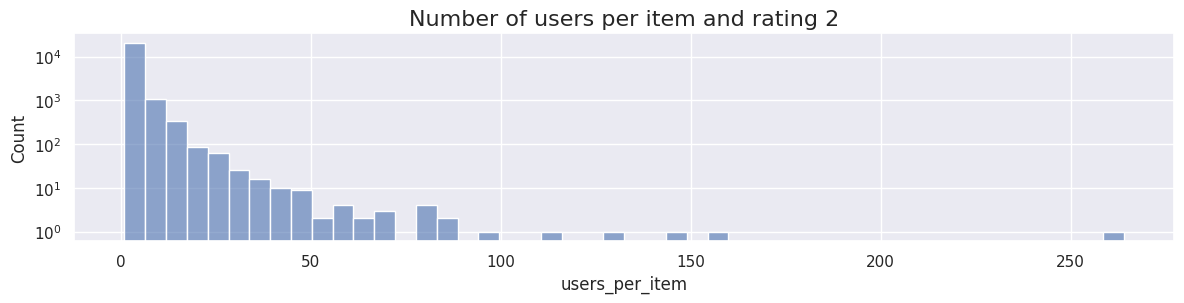

2024-12-03 11:39:12,364 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/users_per_item_rating_2_hist.png


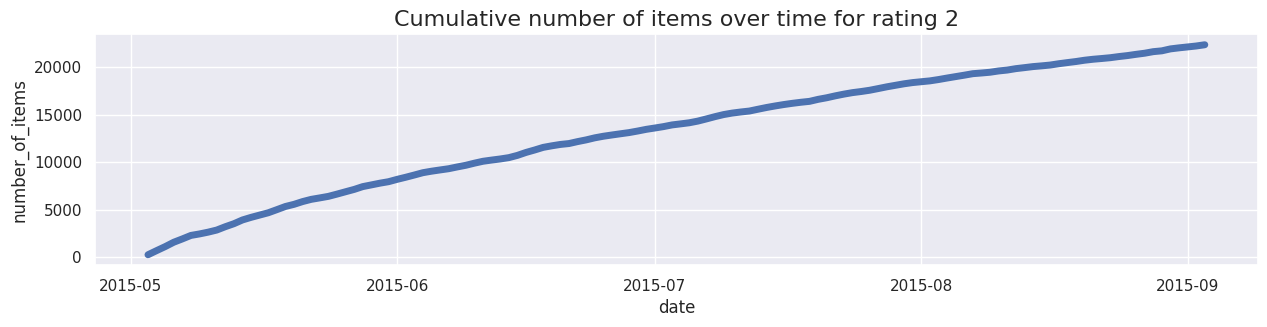

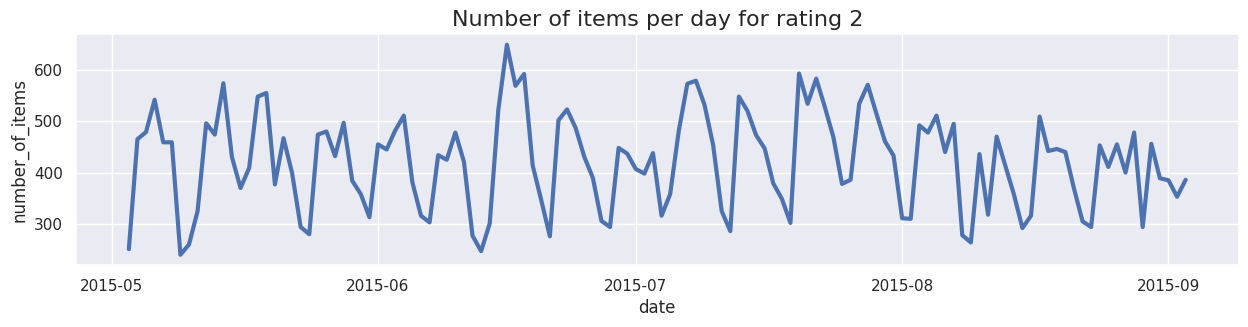


----- USERS PER ITEM FOR RATING 3 -----

Number of unique items: 11189

Quantiles
|    |   quantiles |   users_per_item |
|---:|------------:|-----------------:|
|  0 |       0.1   |            1     |
|  1 |       0.2   |            1     |
|  2 |       0.3   |            1     |
|  3 |       0.4   |            1     |
|  4 |       0.5   |            1     |
|  5 |       0.6   |            1     |
|  6 |       0.7   |            2     |
|  7 |       0.8   |            2     |
|  8 |       0.9   |            3     |
|  9 |       0.95  |            5     |
| 10 |       0.99  |           10     |
| 11 |       0.999 |           31.812 |


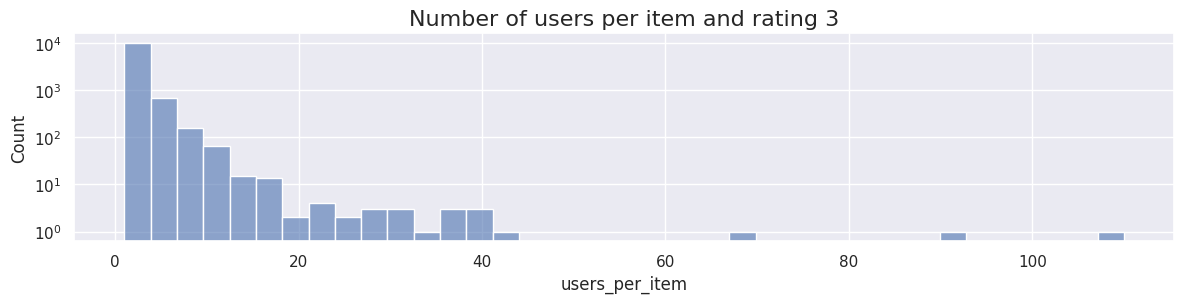

2024-12-03 11:39:14,222 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/users_per_item_rating_3_hist.png


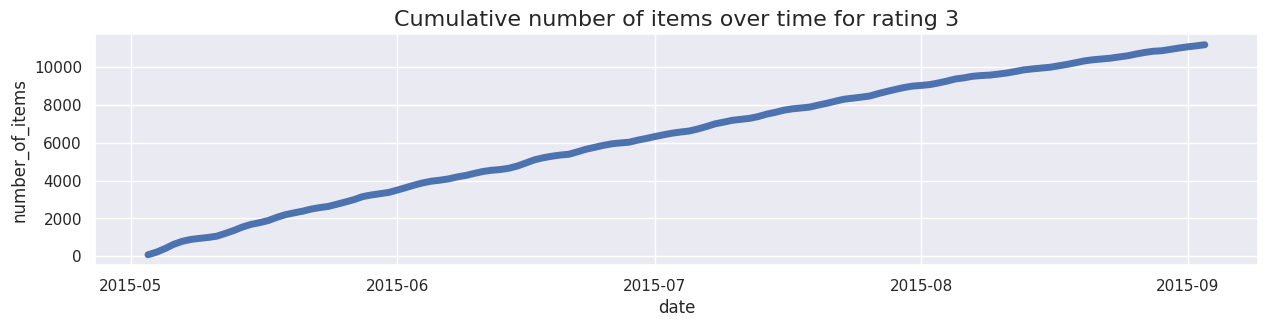

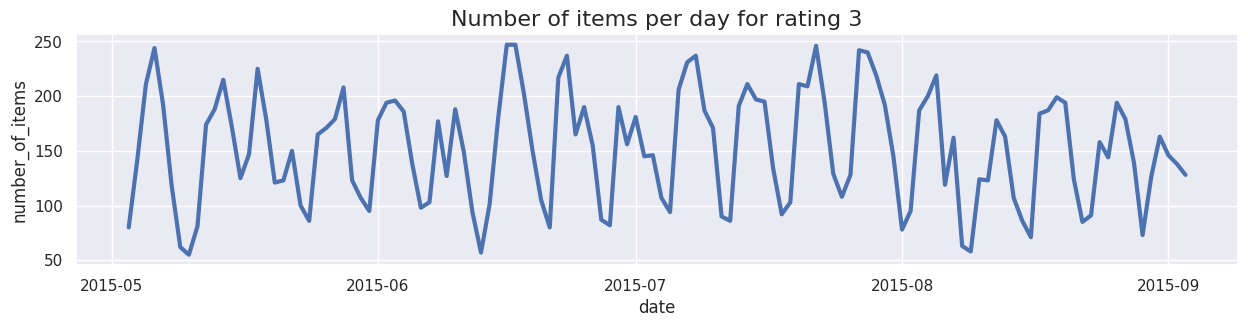

2024-12-03 11:39:15,053 [recsys_experiments] [item_analysis] - INFO: Finished item analysis


In [19]:
component.item_analysis()

1. Top items lie far from the rest according to the hist plots.  
Those items are probably very low on price and constantly required in everyday life.
2. 70 % of items have been `viewed` only at most 6 times.  
It is better to omit these items so that too noisy items with no popularity are not included in the recommendation models.  
As a result, the offline recommendations will be more accurate, although at the cost of item coverage and also user coverage   
since omitting items leads to omitting a certain amount of users that have only viewed those items.
3. 40 % of `added to cart` items were added only ones
4. 60 % of `transaction` items were purchased only ones
5. The `add to cart` to `view` ratio  is about 10% (22347 to 225099)
6. The `transaction` to `add to cart` ratio is about 50% (11189 to 22347).
7. The `number of items per day` have a clear week and month seasonalities with no clear trend for all cases.   
This means that week-based and month-based lag features might be important
8. Though there is no clear trend for `number of items per day`, the `number of items` is constantly increasing for all cases.

## <p style="color: #999900;"> 3. Category tree analysis </p>

2024-12-03 11:39:15,187 [recsys_experiments] [read_parquet] - INFO: Read category_tree.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.


Number of unique categories: 1669
No cycles detected in the item category tree.


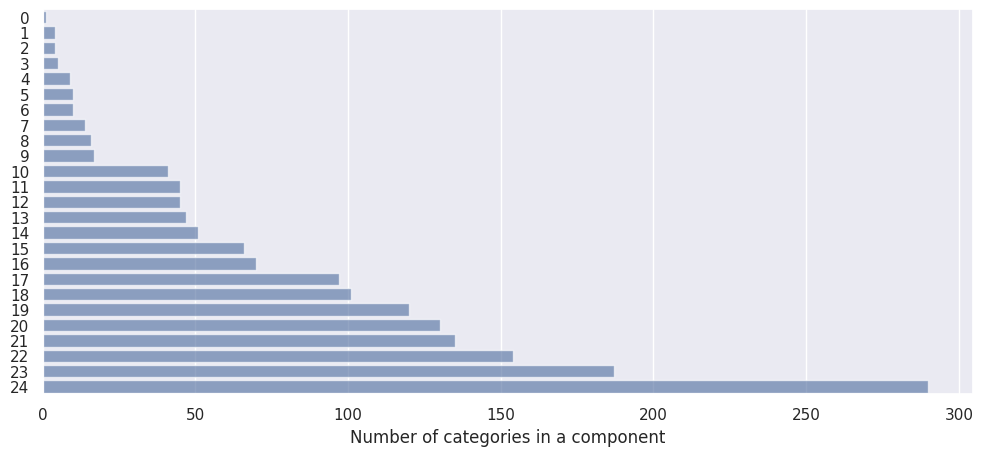

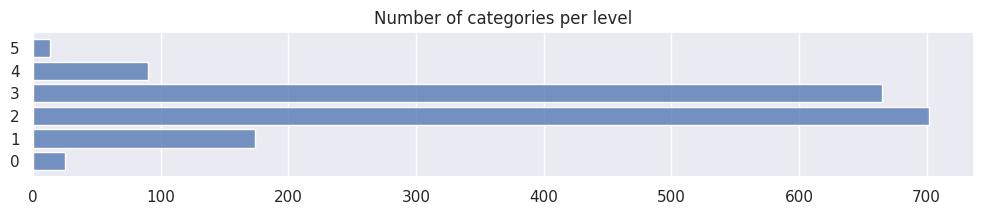

2024-12-03 11:39:16,194 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/category_tree_node_level_distribution.png
Number of root categories: 25
Root categories: [378, 250, 1490, 1394, 395, 140, 653, 1532, 679, 859, 1579, 1600, 803, 1482, 791, 431, 755, 1224, 1698, 659, 1057, 1452, 1182, 1692, 231]
Number of leaf categories: 1307


In [20]:
node_levels, G = component.category_tree_analysis()

1. There are 1669 unique item categories
2. There are 25 root categories (connectivity components)
3. The most number of categories are at the level (depth) of 2 and 3

## <p style="color: #999900;"> 4. Item features analysis </p>

2024-12-03 11:40:13,001 [recsys_experiments] [read_parquet] - INFO: Read availability.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.


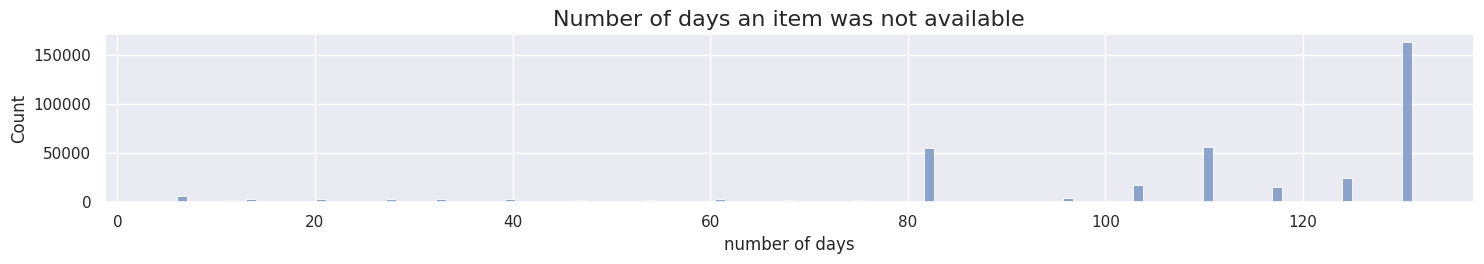

2024-12-03 11:40:13,848 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/days_item_availability_0_hist.png


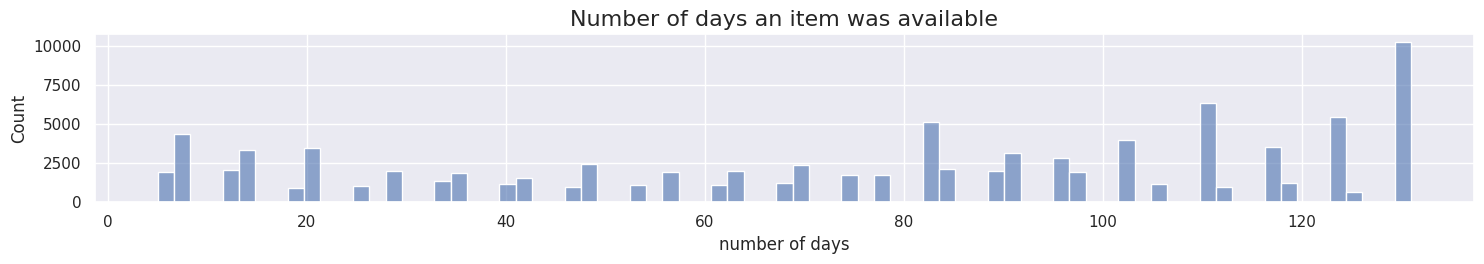

2024-12-03 11:40:14,387 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/days_item_availability_1_hist.png


In [26]:
component.item_availability_analysis()

1. If an item was not available at some point, it tends to be unavailable for a long time (at least 80 days)
2. If an item was available at some point, it tends to be available for a long time but not at the same degree as in case of unavailability

2024-12-03 11:40:18,283 [recsys_experiments] [read_parquet] - INFO: Read category.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
Number of categories not in tree: 30


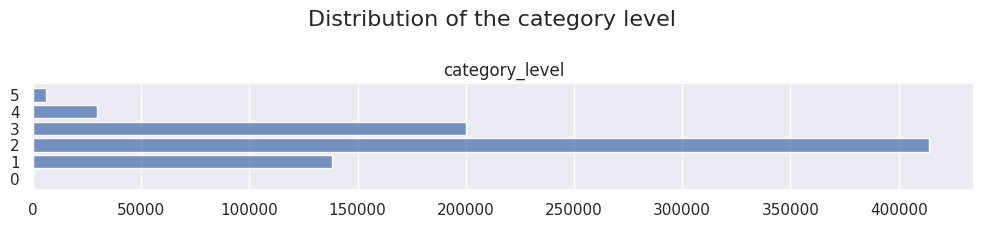

2024-12-03 11:40:18,904 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/category_level_hist.png


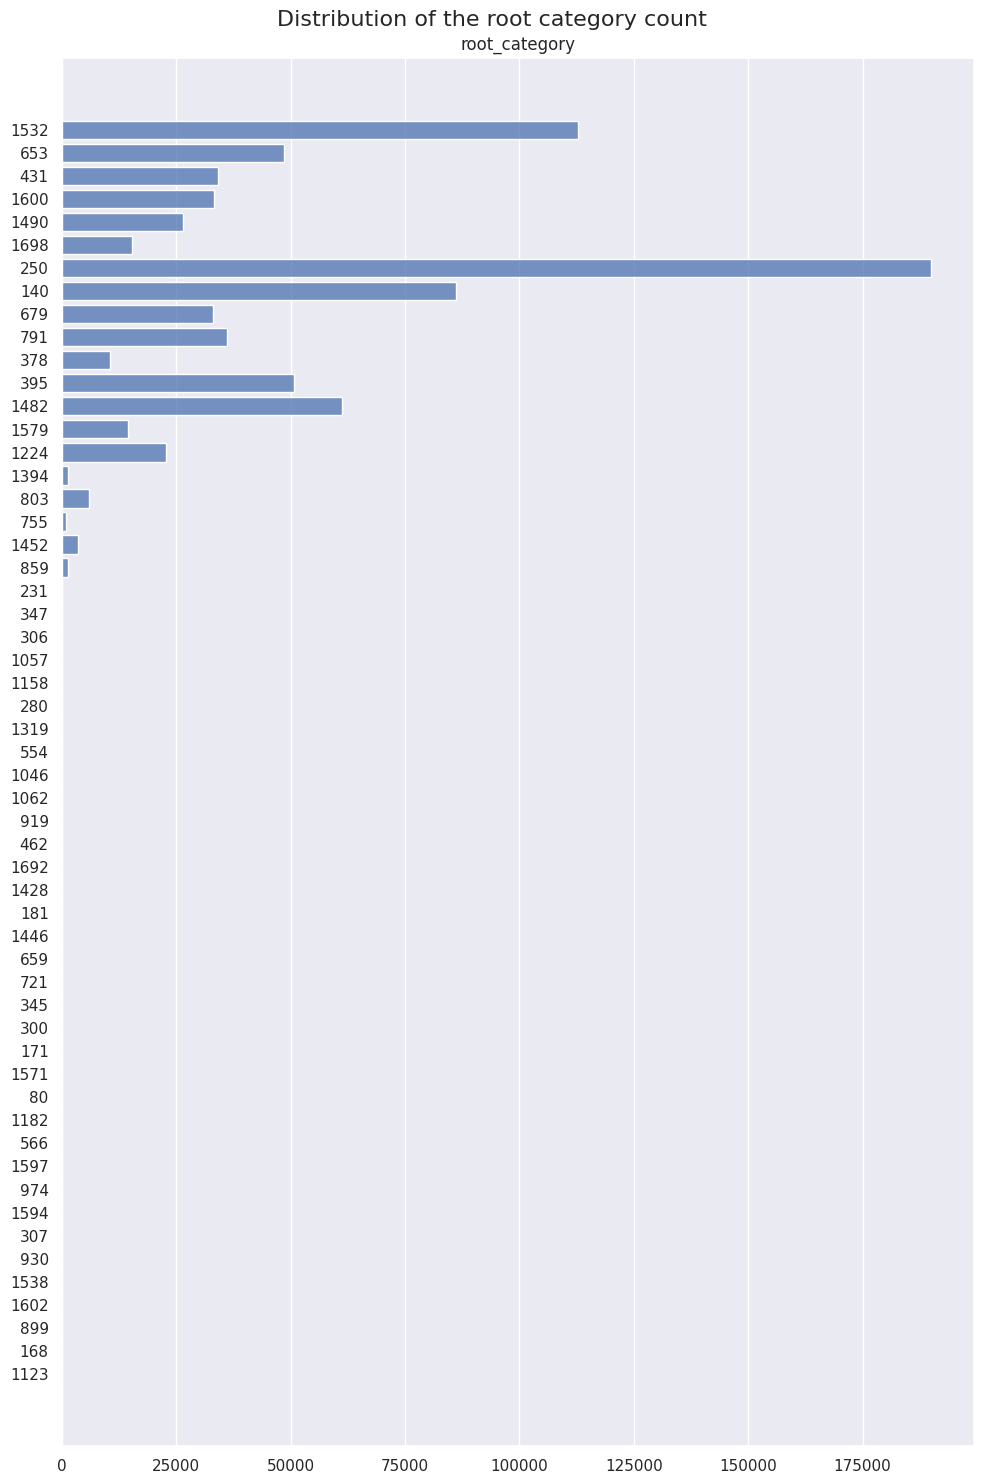

2024-12-03 11:40:20,852 [recsys_experiments] [custom_hist_multiplot] - INFO: custom_hist_multiplot saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/eda/assets/root_category_count_hist.png


In [27]:
component.item_category_analysis(G, node_levels)

1. There are 30 item categories that were not specified in the category tree. Therefore there are 55 root categories in total.
2. 38 root item categories have almost no corresponding items.
3. Category 250 is the most broad root category

## <p style="color: #999900;"> 5. Logging </p>

In [6]:
component.log()

2024-12-03 12:59:06,621 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-comm' exists


2024/12/03 12:59:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run eda at: http://localhost:5000/#/experiments/32/runs/a7e0b40354fa49b5bb406f213aa76666.
2024/12/03 12:59:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/32.


In [ ]:
exit(0)

: 

# <p style="color: #33FF33; text-align:center;"> STAGE III. Data Preparation </p>

<p style="color: #FF0000; font-size:24px;"> Restart the notebook before proceeding </p>

It was shown that the sparsity is too high. Therefore, there a recommendation model will be trained using `scipy sparse matrix` data representation


Therefore, it is necessary to build sparse matrices - for user-items data and item-features data

In [7]:
component = MatrixBuilderComponent(print_info=True, is_testing=True)
component2 = MatrixBuilderComponent(print_info=True, is_testing=False)

2024-12-03 16:20:38,807 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/config/components.yaml has been loaded
2024-12-03 16:20:38,809 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/config/dates.yaml has been loaded
2024-12-03 16:20:38,811 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/config/airflow.yaml has been loaded
2024-12-03 16:20:38,813 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/config/experiment_name.yaml has been loaded


## <p style="color: #999900;"> 1. Encoding user ID and item ID </p>

This section is necessary in order to build a sparse matrix for user-items data.

The process is done iteratively over partitions, so that less RAM is consumed.

In [9]:
component.fit_encoders()

2024-12-03 11:34:46,334 [recsys_experiments] [fit_encoders] - INFO: Processed all batches
2024-12-03 11:34:46,382 [recsys_experiments] [fit_encoders] - INFO: Fitted an encoder for item ID
2024-12-03 11:34:46,387 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item.pkl
2024-12-03 11:34:46,640 [recsys_experiments] [fit_encoders] - INFO: Fitted an encoder for user ID
2024-12-03 11:34:46,651 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_user.pkl


In [10]:
component2.fit_encoders()

2024-12-03 11:34:50,463 [recsys_experiments] [fit_encoders] - INFO: Processed all batches
2024-12-03 11:34:50,511 [recsys_experiments] [fit_encoders] - INFO: Fitted an encoder for item ID
2024-12-03 11:34:50,514 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_item.pkl
2024-12-03 11:34:50,817 [recsys_experiments] [fit_encoders] - INFO: Fitted an encoder for user ID
2024-12-03 11:34:50,829 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl


## <p style="color: #999900;"> 2. Building item-categories matrix </p>

In [10]:
component.build_item_features_matrix()

2024-12-03 16:23:01,857 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item.pkl has been loaded
2024-12-03 16:23:01,902 [recsys_experiments] [build_item_features_matrix] - INFO: Left with 384705 (48.81%) items
2024-12-03 16:23:01,929 [recsys_experiments] [build_item_features_matrix] - INFO: Dropped 50.06% of rows due to duplicates. 192134 rows left
2024-12-03 16:23:01,954 [recsys_experiments] [build_item_features_matrix] - INFO: Fitted an encoder for item category
2024-12-03 16:23:01,955 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item_category.pkl
2024-12-03 16:23:01,963 [recsys_experiments] [build_item_features_matrix] - INFO: Built item-category sparse matrix
2024-12-03 16:23:02,805 [recsys_experiments] [build_item_features_matrix] - INFO: item-c

In [11]:
component2.build_item_features_matrix()

2024-12-03 16:23:02,845 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_item.pkl has been loaded
2024-12-03 16:23:02,890 [recsys_experiments] [build_item_features_matrix] - INFO: Left with 399425 (50.67%) items


2024-12-03 16:23:02,915 [recsys_experiments] [build_item_features_matrix] - INFO: Dropped 50.01% of rows due to duplicates. 199684 rows left
2024-12-03 16:23:02,942 [recsys_experiments] [build_item_features_matrix] - INFO: Fitted an encoder for item category
2024-12-03 16:23:02,943 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_item_category.pkl
2024-12-03 16:23:02,951 [recsys_experiments] [build_item_features_matrix] - INFO: Built item-category sparse matrix
2024-12-03 16:23:03,940 [recsys_experiments] [build_item_features_matrix] - INFO: item-category matrix info: number of items - 185246, number of features - 1156, number of data points - 199684, sparsity - 99.9068%


## <p style="color: #999900;"> 3. Building user-items matrix </p>

The matrix is filled in separately for each partition, so that less RAM is consumed.

In [11]:
component.build_user_items_matrix()

2024-12-03 11:34:59,074 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_user.pkl has been loaded
2024-12-03 11:34:59,076 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item.pkl has been loaded


2024-12-03 11:35:30,611 [recsys_experiments] [build_user_items_matrix] - INFO: Build user-items sparse matrix
2024-12-03 11:35:32,398 [recsys_experiments] [build_user_items_matrix] - INFO: user-items matrix info: number of users - 1278801, number of items - 225307, number of events - 1948095, sparsity - 99.9993%


In [12]:
component2.build_user_items_matrix()

2024-12-03 11:35:32,465 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded
2024-12-03 11:35:32,467 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_item.pkl has been loaded


2024-12-03 11:36:06,689 [recsys_experiments] [build_user_items_matrix] - INFO: Build user-items sparse matrix
2024-12-03 11:36:08,637 [recsys_experiments] [build_user_items_matrix] - INFO: user-items matrix info: number of users - 1407580, number of items - 235061, number of events - 2145179, sparsity - 99.9994%


Logging

In [8]:
component.log()

2024-12-03 12:59:18,904 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-comm' exists


2024/12/03 12:59:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run matrices__testing at: http://localhost:5000/#/experiments/32/runs/94523278cf80454e9121c45faa67f692.
2024/12/03 12:59:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/32.


In [9]:
component2.log()

2024-12-03 12:59:20,434 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-comm' exists


2024/12/03 12:59:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run matrices at: http://localhost:5000/#/experiments/32/runs/8b7dad1cc54f4cfdadebc225d6ae53da.
2024/12/03 12:59:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/32.


In [ ]:
exit(0)

: 

## <p style="color: #999900;"> 4. Creating user and item features </p>

Since a ranking model will be used over recommendation models, it might benefit from user and item features. Let's build most common ones using a separate component.

In [62]:
component1 = FeaturesGeneratorComponent(is_testing=True)
component2 = FeaturesGeneratorComponent(is_testing=False)

In [48]:
component1.generate_item_features()

2024-12-03 17:50:48,501 [recsys_experiments] [read_parquet] - INFO: Read events_train.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
2024-12-03 17:50:49,447 [recsys_experiments] [read_parquet] - INFO: Read availability.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
2024-12-03 17:50:49,832 [recsys_experiments] [read_parquet] - INFO: Read category.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
2024-12-03 17:50:50,230 [recsys_experiments] [save_parquet] - INFO: Saved item_features.parquet to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/features/testing.
2024-12-03 17:50:50,232 [recsys_experiments] [generate_item_features] - INFO: Generated item features.


In [49]:
component2.generate_item_features()

2024-12-03 17:50:50,521 [recsys_experiments] [read_parquet] - INFO: Read events.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
2024-12-03 17:50:51,467 [recsys_experiments] [read_parquet] - INFO: Read availability.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
2024-12-03 17:50:51,850 [recsys_experiments] [read_parquet] - INFO: Read category.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
2024-12-03 17:50:52,202 [recsys_experiments] [save_parquet] - INFO: Saved item_features.parquet to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/features/not_testing.
2024-12-03 17:50:52,203 [recsys_experiments] [generate_item_features] - INFO: Generated item features.


The following features were generated for `items`:
- `users_per_item` for each rating
- `users_per_item` since last 28 days for each rating
- the number of days since the first `interaction` for an `item` for each rating
- the number of days since the last `interaction` for an `item` for each rating
- number of days an item was available
- number of days an item was unavailable
- category level of the item


In [63]:
component1.generate_user_features()

2024-12-03 17:56:33,452 [recsys_experiments] [read_parquet] - INFO: Read events_train.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
2024-12-03 17:56:35,243 [recsys_experiments] [save_parquet] - INFO: Saved user_features.parquet to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/features/testing.
2024-12-03 17:56:35,245 [recsys_experiments] [generate_user_features] - INFO: Generated user features.


In [64]:
component2.generate_user_features()

2024-12-03 17:56:35,441 [recsys_experiments] [read_parquet] - INFO: Read events.parquet from /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/preprocessing.
2024-12-03 17:56:37,467 [recsys_experiments] [save_parquet] - INFO: Saved user_features.parquet to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/features/not_testing.
2024-12-03 17:56:37,468 [recsys_experiments] [generate_user_features] - INFO: Generated user features.


The following features were generated for `users`:
- `items_per_user` for each rating
- `items_per_user` since last 28 days for each rating
- the number of days since the first `interaction` for a `user` for each rating
- the number of days since the last `interaction` for a `user` for each rating


ALthough it is possible to come up with more features, let's leave it as it is for now.

Logging

In [11]:
component1.log()

2024-12-03 12:59:31,081 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-comm' exists


2024/12/03 12:59:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run features_generation__testing at: http://localhost:5000/#/experiments/32/runs/52d92c451c134a908aa58de0f6d1f741.
2024/12/03 12:59:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/32.


In [12]:
component2.log()

2024-12-03 12:59:32,412 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-comm' exists


2024/12/03 12:59:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run features_generation at: http://localhost:5000/#/experiments/32/runs/3df5ab1a671247059b0c3149c729b21c.
2024/12/03 12:59:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/32.


In [ ]:
exit(0)

: 

# <p style="color: #33FF33; text-align:center;"> STAGE IV. Modelling </p>

## <p style="color: #999900;"> 1. Base recommendation models </p>

The base recommendation models will be:
- ALS (Alternating Least Squares)
- BPR (Bayesian Personalized Ranking)
- item2item (based on item categories)
- top N popular items (top N items with the highest number of interactions)

Item2Item model works with item-features matrix built from item categories data. Given a user ID and events history data (which items have been interacted with by a user), it computes an average item-features vector and then finds top items according to the similarity criteria. To speed up the computation, the following was used:
- TruncatedSVD algorithm - reduces the number of item features
- NearestNeighbors algorithm - a much faster computation of the closest item-features vectors for a given vector

It is important to note that 
- old `(user, item)` pairs will be recommended since certain items were at least viewed multiple times by one user.
- items that are not 'currently' available will be used for training, but not used for recommendations.

As it was pointed out, it is essential to omit too unpopular items in order to improve the quality of the recommendations. The following cut-off values for the number of users per item will be used:
- ALS: 5
- BPR: 5
- item2item: 5

### <p style="color: #999900;"> I. ALS model </p>

<p style="color: #FF0000; font-size:20px;"> Restart the notebook before proceeding </p>

In [8]:
component1 = ALSModelComponent(is_testing=True)
component2 = ALSModelComponent(is_testing=False)

In [41]:
component1.fit()

2024-12-03 11:56:55,054 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item.pkl has been loaded
2024-12-03 11:56:55,062 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_user.pkl has been loaded
2024-12-03 11:56:55 [ALS] [fit] - INFO: Left with 76422 (33.92%) popular items
2024-12-03 11:56:55 [ALS] [fit] - INFO: Left with 1110974 (86.88%) active users
2024-12-03 11:56:55 [ALS] [fit] - INFO: Fitted item_id encoder
2024-12-03 11:56:55 [ALS] [fit] - INFO: Fitted user_id encoder


  0%|          | 0/15 [00:00<?, ?it/s]

2024-12-03 12:22:20 [ALS] [fit] - INFO: Fitted ALS model
2024-12-03 12:22:20,887 [recsys_experiments] [fit] - INFO: Trained ALS model
2024-12-03 12:22:35,938 [recsys_experiments] [fit] - INFO: Saved ALS model


In [4]:
component2.fit()

2024-12-03 13:17:54,570 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_item.pkl has been loaded


2024-12-03 13:17:54,663 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded
2024-12-03 13:17:54 [ALS] [fit] - INFO: Left with 81905 (34.84%) popular items
2024-12-03 13:17:54 [ALS] [fit] - INFO: Left with 1234993 (87.74%) active users
2024-12-03 13:17:54 [ALS] [fit] - INFO: Fitted item_id encoder
2024-12-03 13:17:54 [ALS] [fit] - INFO: Fitted user_id encoder


  0%|          | 0/15 [00:00<?, ?it/s]

2024-12-03 13:46:10 [ALS] [fit] - INFO: Fitted ALS model
2024-12-03 13:46:10,924 [recsys_experiments] [fit] - INFO: Trained ALS model
2024-12-03 13:46:27,036 [recsys_experiments] [fit] - INFO: Saved ALS model
2024-12-03 13:46:28 [ALS] [get_similar_items] - INFO: Found 47780 (58.34%) items from 81905 to be filtered
2024-12-03 13:47:17 [ALS] [get_similar_items] - INFO: Generated similar items
2024-12-03 13:47:18 [ALS] [get_similar_items] - INFO: Prepared a dataframe with similar items
2024-12-03 13:47:18,366 [recsys_experiments] [fit] - INFO: Saved similar items data


In [14]:
component1.recommend()

2024-12-03 13:00:02,522 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-12-03 13:00:02,527 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'target'
2024-12-03 13:00:04,187 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/als/testing/als.pkl has been loaded
2024-12-03 13:00:04 [ALS] [recommend] - INFO: Found 300 (15.27%) users from 1964 in the model
2024-12-03 13:00:04 [ALS] [recommend] - INFO: Found 44595 (58.35%) items from 76422 to be filtered
2024-12-03 13:00:04 [ALS] [recommend] - INFO: Filtered user_items_matrix
2024-12-03 13:00:04 [ALS] [recommend] - INFO: Generated recommendations
2024-12-03 13:00:04 [ALS] [recommend] - INFO: Prepared a Dataframe with recommendations
2024-12-03 13:00:04,589 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'target'
2024-12-03 13:00:05,193 [recsys_experiments] [recommend] - INFO: Loaded

In [5]:
component2.recommend()

2024-12-03 13:47:27,003 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-12-03 13:47:27,013 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded
2024-12-03 13:47:27,063 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'all'
2024-12-03 13:47:29,044 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/als/not_testing/als.pkl has been loaded
2024-12-03 13:47:29 [ALS] [recommend] - INFO: Found 1234993 (87.74%) users from 1407580 in the model
2024-12-03 13:47:29 [ALS] [recommend] - INFO: Found 47780 (58.34%) items from 81905 to be filtered
2024-12-03 13:47:29 [ALS] [recommend] - INFO: Filtered user_items_matrix
2024-12-03 13:58:28 [ALS] [recommend] - INFO: Generated recommendations
2024-12-03 13:58:46 [ALS] [recommend] - INFO: Pr

In [21]:
component2.recommend()

2024-12-01 22:29:15,016 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-12-01 22:29:15,025 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded
2024-12-01 22:29:15,060 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'all'
2024-12-01 22:29:17,107 [recsys_experiments] [read_pkl] - INFO: Model /home/ubuntu2/recommendation_system_in_e-commerce/experiments/artifacts/modelling/als/not_testing/als.pkl has been loaded
2024-12-01 22:29:17 [ALS] [recommend] - INFO: Found 1110974 (86.88%) users from 1278801 in the model
2024-12-01 22:29:17 [ALS] [recommend] - INFO: Found 45053 (58.95%) items from 76422 to be filtered
2024-12-01 22:29:17 [ALS] [recommend] - INFO: Filtered user_items_matrix
2024-12-01 22:29:26 [ALS] [recommend] - INFO: Generated recommendations
2024-12-01 22:29:45 [ALS] [recommend] - INFO: Prepared a Dataframe with reco

In [15]:
component1.evaluate()

Evaluating recommendations:   0%|          | 0/1805 [00:00<?, ?it/s]

2024-12-03 13:00:15,795 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision10': 0.006426521620329821, 'Recall10': 0.04023834199969402, 'NDCG10': 0.03290610550848388, 'CoverageItem10': 0.11762133799737648, 'CoverageUser10': 0.13185595567867037}
2024-12-03 13:00:15,798 [recsys_experiments] [save_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/als/testing/metrics.yaml has been written successfully.


In [16]:
component1.log()

2024-12-03 13:00:31,518 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-comm' exists


2024-12-03 13:00:36,217 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/als/testing/metrics.yaml has been loaded


2024/12/03 13:00:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run base_model_als__testing at: http://localhost:5000/#/experiments/32/runs/9b6405e87ee24e2282684607d11f9922.
2024/12/03 13:00:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/32.


In [ ]:
component2.log()

In [ ]:
exit(0)

: 

### <p style="color: #999900;"> II. BPR model </p>

<p style="color: #FF0000; font-size:20px;"> Restart the notebook before proceeding </p>

In [34]:
component1 = BPRModelComponent(is_testing=True)
component2 = BPRModelComponent(is_testing=False)

In [35]:
component1.fit()

2024-12-03 11:41:21,764 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item.pkl has been loaded
2024-12-03 11:41:21,769 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_user.pkl has been loaded


2024-12-03 11:41:21 [BPR] [fit] - INFO: Filtered 76422 (33.92%) popular items
2024-12-03 11:41:21 [BPR] [fit] - INFO: Filtered 1110974 (86.88%) active users
2024-12-03 11:41:21 [BPR] [fit] - INFO: Fitted item_id encoder
2024-12-03 11:41:21 [BPR] [fit] - INFO: Fitted user_id encoder


  0%|          | 0/50 [00:00<?, ?it/s]

2024-12-03 11:42:01 [BPR] [fit] - INFO: Fitted BPR model
2024-12-03 11:42:01,361 [recsys_experiments] [fit] - INFO: Trained BPR model
2024-12-03 11:42:16,511 [recsys_experiments] [fit] - INFO: Saved BPR model


In [36]:
component2.fit()

2024-12-03 11:42:27,326 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_item.pkl has been loaded
2024-12-03 11:42:27,335 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded
2024-12-03 11:42:27 [BPR] [fit] - INFO: Filtered 81905 (34.84%) popular items
2024-12-03 11:42:27 [BPR] [fit] - INFO: Filtered 1234993 (87.74%) active users
2024-12-03 11:42:27 [BPR] [fit] - INFO: Fitted item_id encoder
2024-12-03 11:42:27 [BPR] [fit] - INFO: Fitted user_id encoder


  0%|          | 0/50 [00:00<?, ?it/s]

2024-12-03 11:43:07 [BPR] [fit] - INFO: Fitted BPR model
2024-12-03 11:43:07,731 [recsys_experiments] [fit] - INFO: Trained BPR model
2024-12-03 11:43:24,684 [recsys_experiments] [fit] - INFO: Saved BPR model
2024-12-03 11:43:25 [BPR] [get_similar_items] - INFO: Found 47780 (58.34%) items from81905 to be filtered
2024-12-03 11:44:16 [BPR] [get_similar_items] - INFO: Generated similar items
2024-12-03 11:44:17 [BPR] [get_similar_items] - INFO: Prepared a Dataframe with similar items
2024-12-03 11:44:17,509 [recsys_experiments] [fit] - INFO: Generated similar items
2024-12-03 11:44:17,640 [recsys_experiments] [fit] - INFO: Saved similar items data


In [37]:
component1.recommend()

2024-12-03 11:44:18,342 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-12-03 11:44:18,347 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'target'
2024-12-03 11:44:19,898 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/bpr/testing/bpr.pkl has been loaded
2024-12-03 11:44:20 [BPR] [recommend] - INFO: Found 300 (15.27%) users from 1964 in the model
2024-12-03 11:44:20 [BPR] [recommend] - INFO: Found 44595 (58.35%) items from 76422 to be filtered
2024-12-03 11:44:20 [BPR] [recommend] - INFO: Filtered user_items_matrix
2024-12-03 11:44:20 [BPR] [recommend] - INFO: Generated recommendations
2024-12-03 11:44:20 [BPR] [recommend] - INFO: Prepared a Dataframe with recommendations
2024-12-03 11:44:20,334 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'target'
2024-12-03 11:44:20,435 [recsys_experiments] [recommend] - INFO: Loaded

In [39]:
component2.recommend()

2024-12-03 11:45:02,118 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-12-03 11:45:02,123 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded
2024-12-03 11:45:02,147 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'all'
2024-12-03 11:45:03,793 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/bpr/not_testing/bpr.pkl has been loaded
2024-12-03 11:45:04 [BPR] [recommend] - INFO: Found 1234993 (87.74%) users from 1407580 in the model
2024-12-03 11:45:04 [BPR] [recommend] - INFO: Found 47780 (58.34%) items from 81905 to be filtered
2024-12-03 11:45:04 [BPR] [recommend] - INFO: Filtered user_items_matrix
2024-12-03 11:56:34 [BPR] [recommend] - INFO: Generated recommendations
2024-12-03 11:56:52 [BPR] [recommend] - INFO: Pr

In [38]:
component1.evaluate()

Evaluating recommendations:   0%|          | 0/1805 [00:00<?, ?it/s]

2024-12-03 11:44:40,745 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision10': 0.007766349065548552, 'Recall10': 0.04892460307585564, 'NDCG10': 0.03690480391737965, 'CoverageItem10': 0.13073895933537386, 'CoverageUser10': 0.13185595567867037}
2024-12-03 11:44:40,747 [recsys_experiments] [save_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/bpr/testing/metrics.yaml has been written successfully.


In [21]:
component1.log()

2024-12-01 22:32:39,405 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-commerce' exists


2024-12-01 22:32:43,955 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/bpr/testing/metrics.yaml has been loaded


2024/12/01 22:32:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run base_model_bpr__testing at: http://127.0.0.1:5000/#/experiments/16/runs/b4c045facfc2461b8b82d77a5b783a70.
2024/12/01 22:32:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/16.


In [22]:
component2.log()

2024-12-01 22:32:44,116 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-commerce' exists


2024/12/01 22:32:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run base_model_bpr at: http://127.0.0.1:5000/#/experiments/16/runs/8577a16c1e4f4dcd96389ebbc7661591.
2024/12/01 22:32:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/16.


In [ ]:
exit(0)

### <p style="color: #999900;"> III. Item2Item model </p>

In [3]:
component1 = Item2ItemModelComponent(is_testing=True)
component2 = Item2ItemModelComponent(is_testing=False)

In [7]:
component1.fit()

2024-12-03 17:11:39,377 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item.pkl has been loaded
2024-12-03 17:11:39,384 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_user.pkl has been loaded
2024-12-03 17:11:39 [Item2ItemModel] [fit] - INFO: Left with 187674 (83.3%) popular items with some data
2024-12-03 17:11:39 [Item2ItemModel] [fit] - INFO: Left with 1152 (100.0%) features with some data
2024-12-03 17:11:39 [Item2ItemModel] [fit] - INFO: Left with 1230443 (96.22%) active users
2024-12-03 17:11:39 [Item2ItemModel] [fit] - INFO: Fitted item_id encoder
2024-12-03 17:11:39 [Item2ItemModel] [fit] - INFO: Fitted user_id encoder
2024-12-03 17:11:40 [Item2ItemModel] [fit] - INFO: Fitted TruncatedSVD model
2024-12-03 17:11:40 [Item2ItemModel] [fit] - INFO: Total Explained V

In [9]:
component2.fit()

2024-12-03 17:11:45,327 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_item.pkl has been loaded
2024-12-03 17:11:45,337 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded


2024-12-03 17:11:45 [Item2ItemModel] [fit] - INFO: Left with 195513 (83.18%) popular items with some data
2024-12-03 17:11:45 [Item2ItemModel] [fit] - INFO: Left with 1156 (100.0%) features with some data
2024-12-03 17:11:45 [Item2ItemModel] [fit] - INFO: Left with 1357199 (96.42%) active users
2024-12-03 17:11:45 [Item2ItemModel] [fit] - INFO: Fitted item_id encoder
2024-12-03 17:11:45 [Item2ItemModel] [fit] - INFO: Fitted user_id encoder
2024-12-03 17:11:46 [Item2ItemModel] [fit] - INFO: Fitted TruncatedSVD model
2024-12-03 17:11:46 [Item2ItemModel] [fit] - INFO: Total Explained Variance: 0.3953


In [8]:
component1.recommend()

2024-12-03 17:11:42,306 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-12-03 17:11:42,310 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'target'
2024-12-03 17:11:42,392 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/item2item/testing/item2item.pkl has been loaded
2024-12-03 17:11:42 [Item2ItemModel] [recommend] - INFO: Found 138246 (73.66%) items from 187674 to be filtered
2024-12-03 17:11:42 [Item2ItemModel] [recommend] - INFO: Filtered user_items_matrix
2024-12-03 17:11:42 [Item2ItemModel] [recommend] - INFO: Found 311 (15.84%) users from 1964 in the model
2024-12-03 17:11:42 [Item2ItemModel] [recommend] - INFO: Fitted NearestNeighbors model


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-12-03 17:11:43,343 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'target'
2024-12-03 17:11:43,442 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-12-03 17:11:43,454 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'test'
2024-12-03 17:11:43,546 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/item2item/testing/item2item.pkl has been loaded
2024-12-03 17:11:43 [Item2ItemModel] [recommend] - INFO: Found 138246 (73.66%) items from 187674 to be filtered
2024-12-03 17:11:43 [Item2ItemModel] [recommend] - INFO: Filtered user_items_matrix
2024-12-03 17:11:43 [Item2ItemModel] [recommend] - INFO: Found 245 (13.57%) users from 1805 in the model
2024-12-03 17:11:44 [Item2ItemModel] [recommend] - INFO: Fitted NearestNeighbors model


Processing batches:   0%|          | 0/1 [00:00<?, ?it/s]

2024-12-03 17:11:44,283 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'test'


In [11]:
component2.recommend()

2024-12-03 17:11:56,864 [recsys_experiments] [recommend] - INFO: Loaded user_items_matrix
2024-12-03 17:11:56,873 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded
2024-12-03 17:11:56,913 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'all'
2024-12-03 17:11:57,019 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/item2item/not_testing/item2item.pkl has been loaded
2024-12-03 17:11:57 [Item2ItemModel] [recommend] - INFO: Found 143525 (73.41%) items from 195513 to be filtered
2024-12-03 17:11:57 [Item2ItemModel] [recommend] - INFO: Filtered user_items_matrix
2024-12-03 17:11:57 [Item2ItemModel] [recommend] - INFO: Found 1357199 (96.42%) users from 1407580 in the model
2024-12-03 17:11:57 [Item2ItemModel] [recommend] - INFO: Fitted NearestNe

Processing batches:   0%|          | 0/679 [00:00<?, ?it/s]

2024-12-03 17:24:42,770 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'all'


In [10]:
component1.evaluate()

Evaluating recommendations:   0%|          | 0/1805 [00:00<?, ?it/s]

2024-12-03 17:11:50,664 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision10': 0.0015501215631713694, 'Recall10': 0.01179689227291407, 'NDCG10': 0.006193056514676544, 'CoverageItem10': 0.05465675557498907, 'CoverageUser10': 0.1357340720221607}
2024-12-03 17:11:50,666 [recsys_experiments] [save_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/item2item/testing/metrics.yaml has been written successfully.


In [ ]:
component1.log()

In [ ]:
component2.log()

In [ ]:
exit(0)

### <p style="color: #999900;"> IV. Top items recommendations </p>

<p style="color: #FF0000; font-size:20px;"> Restart the notebook before proceeding </p>

In [13]:
component1 = TopItemsModelComponent(is_testing=True)
component2 = TopItemsModelComponent(is_testing=False)

In [14]:
component1.fit()
component2.fit()

2024-12-03 14:18:32,808 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item.pkl has been loaded


2024-12-03 14:18:32,970 [recsys_experiments] [fit] - INFO: Retrieved top 100 most popular items
2024-12-03 14:18:32,974 [recsys_experiments] [fit] - INFO: Saved top items data
2024-12-03 14:18:32,975 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_item.pkl has been loaded
2024-12-03 14:18:33,106 [recsys_experiments] [fit] - INFO: Retrieved top 100 most popular items
2024-12-03 14:18:33,109 [recsys_experiments] [fit] - INFO: Saved top items data


In [15]:
component1.recommend()
component2.recommend()

2024-12-03 14:18:49,652 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'target'
2024-12-03 14:18:49,656 [recsys_experiments] [recommend] - INFO: Loaded top items data
2024-12-03 14:18:49,784 [recsys_experiments] [recommend] - INFO: Filtered out unavailable items
2024-12-03 14:18:49,869 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'target'
2024-12-03 14:18:50,565 [recsys_experiments] [recommend] - INFO: Retrieved user IDs for subset 'test'
2024-12-03 14:18:50,570 [recsys_experiments] [recommend] - INFO: Loaded top items data
2024-12-03 14:18:50,719 [recsys_experiments] [recommend] - INFO: Filtered out unavailable items
2024-12-03 14:18:50,794 [recsys_experiments] [recommend] - INFO: Saved recommendations for subset 'test'
2024-12-03 14:18:51,580 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded
2024-1

In [16]:
component1.evaluate()

Evaluating recommendations:   0%|          | 0/1805 [00:00<?, ?it/s]

2024-12-03 14:19:19,354 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision10': 0.0007756232686980608, 'Recall10': 0.00506393609608738, 'NDCG10': 0.002080268851967948, 'CoverageItem10': 0.0017490161783996502, 'CoverageUser10': 1.0}
2024-12-03 14:19:19,357 [recsys_experiments] [save_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/top_items/testing/metrics.yaml has been written successfully.


In [12]:
component1.log()

2024-12-01 22:23:18,283 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-commerce' exists


2024-12-01 22:23:18,825 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/top_items/testing/metrics.yaml has been loaded


2024/12/01 22:23:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run top_items__testing at: http://127.0.0.1:5000/#/experiments/16/runs/51bcf212858247d0bd21169b0327d4e2.
2024/12/01 22:23:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/16.


In [15]:
component2.log()

2024-12-01 22:25:07,948 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-commerce' exists


2024/12/01 22:25:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run top_items at: http://127.0.0.1:5000/#/experiments/16/runs/9761e1ac39754f2197fbc4ba56fd7520.
2024/12/01 22:25:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/16.


In [ ]:
exit(0)

: 

## <p style="color: #999900;"> 2. Ranking model over base models </p>

The ranking model will be a CatBoostClassifier, which can easily work with missing data (e.g. some user-item candidates might have only one score from a base model) and can handle different scaling

<p style="color: #FF0000; font-size:24px;"> Restart the notebook before proceeding </p>

In [3]:
component1 = EnsembleModelComponent(is_testing=True)
component2 = EnsembleModelComponent(is_testing=False)

In [68]:
component1.prepare_data()
component2.prepare_data()

Merging train_df data:   0%|          | 0/3 [00:00<?, ?it/s]

2024-12-03 17:57:05,979 [recsys_experiments] [_merge_data] - INFO: Merged train_df data.
2024-12-03 17:57:05,986 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item.pkl has been loaded
2024-12-03 17:57:05,993 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_user.pkl has been loaded
2024-12-03 17:57:06,276 [recsys_experiments] [_add_top_items] - INFO: Added top items data.
2024-12-03 17:57:06,292 [recsys_experiments] [_add_target] - INFO: Added target variable for train_df data.
2024-12-03 17:57:06,295 [recsys_experiments] [_add_target] - INFO: Number of positive samples for train_df data: 76 (0.66%) 
2024-12-03 17:57:06,300 [recsys_experiments] [_filter_data] - INFO: Left with 2456 (21.3%) samples after filtering users with no positive targets
2024-12-03 17:57:06,316 [rec

Merging test_df data:   0%|          | 0/3 [00:00<?, ?it/s]

2024-12-03 17:57:06,715 [recsys_experiments] [_merge_data] - INFO: Merged test_df data.
2024-12-03 17:57:06,717 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_item.pkl has been loaded
2024-12-03 17:57:06,724 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/testing/encoder_user.pkl has been loaded
2024-12-03 17:57:06,914 [recsys_experiments] [_add_top_items] - INFO: Added top items data.
2024-12-03 17:57:06,926 [recsys_experiments] [_add_target] - INFO: Added target variable for test_df data.
2024-12-03 17:57:06,928 [recsys_experiments] [_add_target] - INFO: Number of positive samples for test_df data: 48 (0.53%) 
2024-12-03 17:57:07,218 [recsys_experiments] [_add_features] - INFO: Added `user` features
2024-12-03 17:57:07,265 [recsys_experiments] [_add_features] - INFO: Added `item` feat

Merging all data:   0%|          | 0/3 [00:00<?, ?it/s]

2024-12-03 17:57:50,614 [recsys_experiments] [_merge_data] - INFO: Merged all data.
2024-12-03 17:57:50,616 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_item.pkl has been loaded
2024-12-03 17:57:50,621 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/matrices/not_testing/encoder_user.pkl has been loaded
2024-12-03 17:58:52,522 [recsys_experiments] [_add_top_items] - INFO: Added top items data.
2024-12-03 17:59:04,334 [recsys_experiments] [prepare_data] - INFO: Prepared and saved all data.


In [4]:
component1.fit()

2024-12-03 18:06:45,800 [recsys_experiments] [fit] - INFO: Read train data
2024-12-03 18:06:45,808 [recsys_experiments] [fit] - INFO: Read test data
2024-12-03 18:06:45,819 [recsys_experiments] [fit] - INFO: Read real data


Evaluating recommendations:   0%|          | 0/1805 [00:00<?, ?it/s]

2024-12-03 18:06:46,063 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision10': 0.007368882218206892, 'Recall10': 0.04600407037907439, 'NDCG10': 0.034536520550260165, 'CoverageItem10': 0.1320507214691736, 'CoverageUser10': 0.1357340720221607}
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

Evaluating recommendations:   0%|          | 0/1805 [00:00<?, ?it/s]

2024-12-03 18:06:46,228 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision10': 0.007249928699747255, 'Recall10': 0.04435555839183122, 'NDCG10': 0.03017397151245493, 'CoverageItem10': 0.135111499781373, 'CoverageUser10': 0.1357340720221607}


Evaluating recommendations:   0%|          | 0/1805 [00:00<?, ?it/s]

2024-12-03 18:06:49,293 [recsys_experiments] [evaluate_recommendations] - INFO: Metrics for K=10: {'Precision10': 0.008528075579675446, 'Recall10': 0.05162375556619928, 'NDCG10': 0.03651135229207727, 'CoverageItem10': 0.1364232619151727, 'CoverageUser10': 0.1357340720221607}
2024-12-03 18:06:49,298 [recsys_experiments] [select_ensemble_model] - INFO: Selected the best ensemble model: CatBoostClassifier
2024-12-03 18:06:49,304 [recsys_experiments] [save_pkl] - INFO: Model has been saved to /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/ensemble/testing/ensemble.pkl
2024-12-03 18:06:49,306 [recsys_experiments] [select_ensemble_model] - INFO: Saved metrics data
2024-12-03 18:06:49,308 [recsys_experiments] [save_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/ensemble/testing/metrics.yaml has been written successfully.
2024-12-03 18:06:49,309 [recsys_experiments] [select

In [6]:
component2.recommend()

2024-12-03 18:07:21,087 [recsys_experiments] [recommend] - INFO: Read data
2024-12-03 18:07:21,092 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/ensemble/testing/feature_importances.yaml has been loaded
2024-12-03 18:07:21,095 [recsys_experiments] [read_pkl] - INFO: Model /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/ensemble/testing/ensemble.pkl has been loaded


Predicting:   0%|          | 0/503 [00:00<?, ?batch/s]

2024-12-03 18:16:04,369 [recsys_experiments] [recommend] - INFO: Ranked recommendations
2024-12-03 18:16:34,783 [recsys_experiments] [recommend] - INFO: Left only top 10 recommendations
2024-12-03 18:16:38,572 [recsys_experiments] [recommend] - INFO: Saved recommendations


In [28]:
component1.log()

2024-12-01 22:45:59,614 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-commerce' exists
2024-12-01 22:46:00,291 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/ensemble/testing/metrics.yaml has been loaded


2024/12/01 22:46:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run ranking_model__testing at: http://127.0.0.1:5000/#/experiments/16/runs/0fb86ab07b034bcc99856d63822555f7.
2024/12/01 22:46:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/16.


In [29]:
component2.log()

2024-12-01 22:46:01,673 [recsys_experiments] [get_experiment_id] - INFO: Experiment 'recsys_e-commerce' exists


2024/12/01 22:46:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run ranking_model at: http://127.0.0.1:5000/#/experiments/16/runs/16b895d84b294ba28c82e75e96eefebf.
2024/12/01 22:46:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://127.0.0.1:5000/#/experiments/16.


In [ ]:
exit(0)

## <p style="color: #999900;"> 3. Models comparison </p>

Let's collect all metrics that were obtained for base models and the final model + feature importance values

In [7]:
import pandas as pd

components = {
    'als': ALSModelComponent(is_testing=True),
    'bpr': BPRModelComponent(is_testing=True),
    'item2item': Item2ItemModelComponent(is_testing=True),
    'top_items': TopItemsModelComponent(is_testing=True),
    'ensemble': EnsembleModelComponent(is_testing=True),
}

importances = read_yaml(
    Path(
        components['ensemble'].config.destination_path['testing'], 
        components['ensemble'].config.feature_importances_filename)
)

metrics = {}
for component_name, component_class in components.items():
    metrics[component_name] = read_yaml(
        Path(
            component_class.config.destination_path['testing'], 
            component_class.config.metrics_filename
        )
    )

metrics = pd.DataFrame(metrics).T.reset_index().rename(columns={'index':'Model'})

2024-12-03 18:16:43,203 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/ensemble/testing/feature_importances.yaml has been loaded
2024-12-03 18:16:43,206 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/als/testing/metrics.yaml has been loaded
2024-12-03 18:16:43,208 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/bpr/testing/metrics.yaml has been loaded
2024-12-03 18:16:43,210 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e-commerce/experiments/artifacts/modelling/item2item/testing/metrics.yaml has been loaded
2024-12-03 18:16:43,212 [recsys_experiments] [read_yaml] - INFO: YAML file /home/mle-user/mle_projects/recommendation_system_in_e

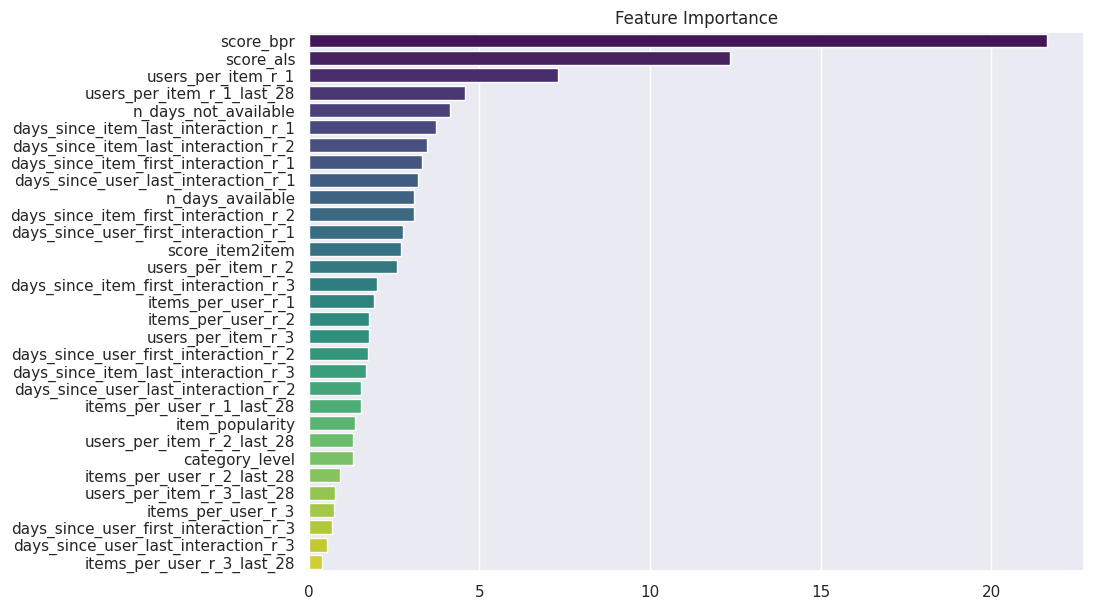

In [8]:
plt.figure(figsize=(10, 7))
sns.barplot(x=importances.values(), y=importances.keys(), palette="viridis")
plt.title('Feature Importance')
plt.show()

1. The most important features by a high margin are `bpr` and `als` model scores
2. The third most important feature is `users_per_item_r1` (i.e. number of users per item for view events)
2. Almost all features in top 15 are item-related, except for both collaborative models scores and only two user-related feature.  
This means that almost all user-related features are not that important and it might be a good idea to remove most of them from the feature set.
3. `category_level` have very low importance

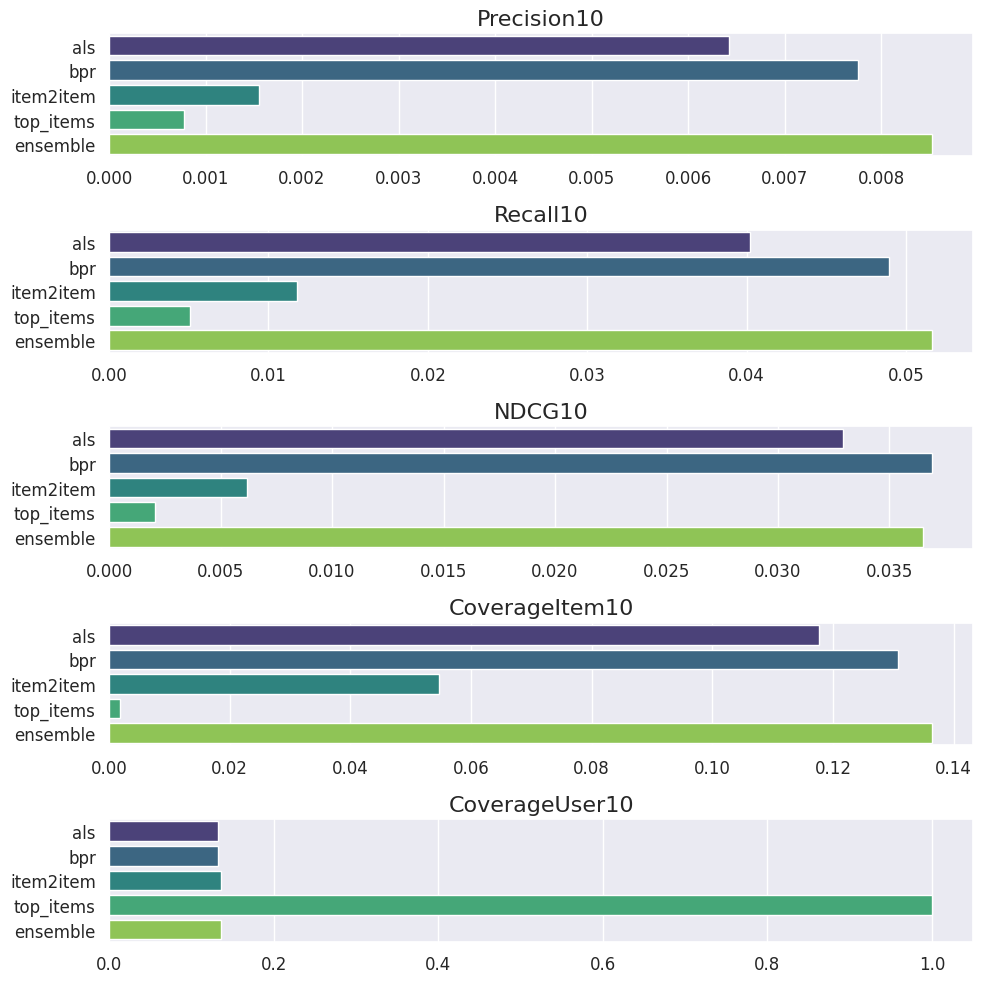

In [11]:
names = list(metrics.columns[1:])

fig, axes = plt.subplots(nrows=len(names), ncols=1, figsize=(10, 2 * len(names)))

if len(metrics) == 1:
    axes = [axes]

# Iterate over metrics and create a horizontal bar plot for each
for ax, metric in zip(axes, names):
    sns.barplot(x=metric, y='Model', data=metrics, ax=ax, palette="viridis")
    ax.set_xlabel('', fontsize=14)
    ax.set_ylabel('', fontsize=14)
    ax.set_title(metric, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

In [10]:
metrics

,Model,Precision10,Recall10,NDCG10,CoverageItem10,CoverageUser10
0,als,0.006427,0.040238,0.032906,0.117621,0.131856
1,bpr,0.007766,0.048925,0.036905,0.130739,0.131856
2,item2item,0.001550,0.011797,0.006193,0.054657,0.135734
3,top_items,0.000776,0.005064,0.002080,0.001749,1.000000
4,ensemble,0.008528,0.051624,0.036511,0.136423,0.135734


Ensemble ranking model slightly improves the performance of the recommendation system comparing to base models achieving
- `Precision@10`: 0.9% (5% - 20% for good models)
- `Recall@10`: 5.2% (1% - 10% for good models)
- `NDCG@10`: 3.7% (10% - 50% for good models)
- `CoverageItem@10`: 13.6%
- `CoverageUser@10`: 13.6%


Coverage metrics were calculated with respect to the total number of users and items in the test set for at least `add_to_cart` events.

The user coverage is only 13.6% because there are only about 14.2% of users in the test set that are present in the training set. So if to consider this metric with respect to 14.2%, the user coverage is good enough.

`Novelty` metric is below 1 by default since the history data shown that there are cases when the same event occured multiple times and therefore all models should be able to recommend the same items.

It is clear, that the quality of the recommendations is not that great according to `Precision@10` - the model is not good enough at recommending relevant items to users, although it is good at detecting relevant items according to `Recall@10`.

All in all, the following steps can be made to improve the quality of the recommendations:
- consider item properties that were temporarily omitted from consideration (ask how this data was hashed in order to restore it)
- consider tuning base models and the ensemble ranking model with implementation in the pipeline
- consider feature selection with implementation in the pipeline
- consider more base models